# Credit Risk Analysis & Default Prediction

## Business Objective

The goal of this project is to build a credit risk model that predicts loan default and identifies key factors associated with default risk.


## Data Description

This dataset contains accepted loan records from Lending Club, including loan characteristics, borrower income, debt-to-income ratio, employment length, and credit score.


### Data Sampling Note

The original Lending Club dataset is very large and is not included in this repository.
A representative sample of the data is used for analysis to ensure reproducibility.


In [6]:
import pandas as pd

# Load cleaned and sampled dataset
df = pd.read_csv("../data/loan_data.csv", low_memory=False)

df.shape


(50000, 151)

In [7]:
# Select key variables relevant for credit risk analysis
cols = [
    "loan_status",
    "loan_amnt",
    "int_rate",
    "annual_inc",
    "dti",
    "fico_range_low",
    "emp_length",
    "term"
]

df = df[cols]
df.head()


,loan_status,loan_amnt,int_rate,annual_inc,dti,fico_range_low,emp_length,term
0,Current,32000.0,10.49,120000.0,24.05,735.0,10+ years,60 months
1,Fully Paid,9600.0,12.99,21900.0,10.03,685.0,NaN,36 months
2,Fully Paid,4000.0,6.68,83000.0,19.53,780.0,4 years,36 months
3,Fully Paid,6025.0,10.91,52000.0,9.16,740.0,10+ years,36 months
4,Current,25000.0,26.30,65000.0,36.26,715.0,10+ years,60 months


## Data Cleaning & Preparation

This section filters loans with final outcomes, creates the target variable, and prepares features for modeling.


In [9]:
# Keep only loans with final outcomes (exclude 'Current')
df = df[df["loan_status"].isin(
    ["Fully Paid", "Charged Off", "Default"]
)]

df["loan_status"].value_counts()


loan_status
Fully Paid     23771
Charged Off     6015
Name: count, dtype: int64

In [10]:
# Create binary target variable: 1 = default, 0 = non-default
df["default"] = df["loan_status"].isin(
    ["Charged Off", "Default"]
).astype(int)

df["default"].value_counts()


default
0    23771
1     6015
Name: count, dtype: int64

In [11]:
# Convert loan term from string to numeric
df["term"] = df["term"].str.replace(" months", "").astype(int)

df["term"].value_counts()


term
36    22531
60     7255
Name: count, dtype: int64

In [12]:
# Clean employment length and convert to numeric
df["emp_length"] = (
    df["emp_length"]
    .str.replace("+", "", regex=False)
    .str.replace(" years", "", regex=False)
    .str.replace(" year", "", regex=False)
)

df["emp_length"] = pd.to_numeric(df["emp_length"], errors="coerce")


In [13]:
# Remove rows with missing values
df = df.dropna()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 25698 entries, 2 to 49999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_status     25698 non-null  object 
 1   loan_amnt       25698 non-null  float64
 2   int_rate        25698 non-null  float64
 3   annual_inc      25698 non-null  float64
 4   dti             25698 non-null  float64
 5   fico_range_low  25698 non-null  float64
 6   emp_length      25698 non-null  float64
 7   term            25698 non-null  int64  
 8   default         25698 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 2.0+ MB


## Exploratory Data Analysis (EDA)

This section explores the relationship between loan default and key risk factors such as interest rate, debt-to-income ratio, and credit score.


In [15]:
# Default rate (important business metric)
default_rate = df["default"].mean()
default_rate


0.19694139621760448

The default rate in the dataset is approximately 19.7%, meaning about one in five loans resulted in default. This indicates a moderately imbalanced dataset, which is typical in credit risk analysis.

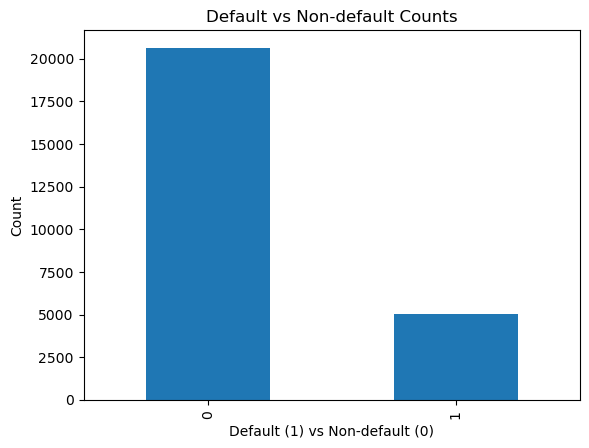

In [17]:
import matplotlib.pyplot as plt

# Count of default vs non-default loans
df["default"].value_counts().plot(kind="bar")
plt.title("Default vs Non-default Counts")
plt.xlabel("Default (1) vs Non-default (0)")
plt.ylabel("Count")
plt.show()


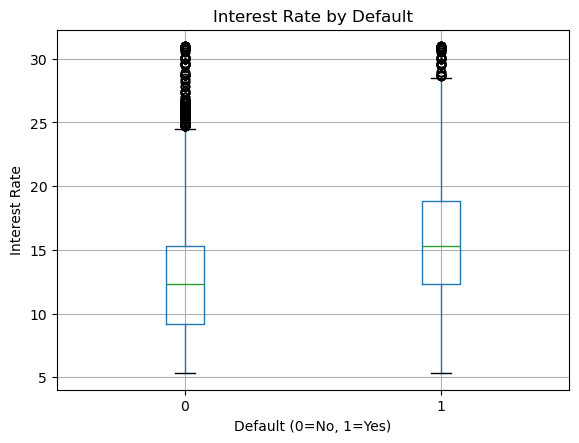

In [18]:
# Interest rate distribution by default outcome
df.boxplot(column="int_rate", by="default")
plt.title("Interest Rate by Default")
plt.suptitle("")
plt.xlabel("Default (0=No, 1=Yes)")
plt.ylabel("Interest Rate")
plt.show()


Loans that defaulted tend to have higher interest rates than non-defaulted loans. This suggests that higher-risk borrowers are charged higher interest rates, but still have a greater probability of default.

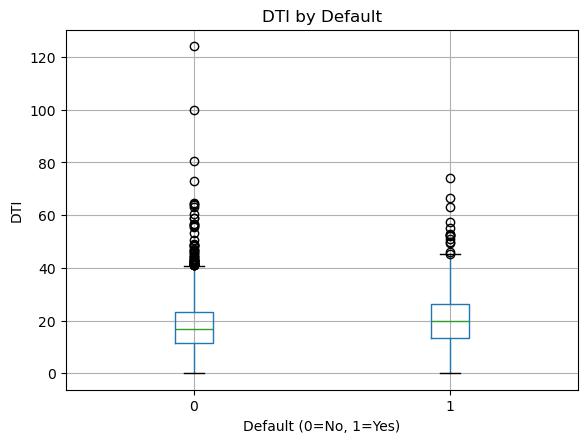

In [20]:
# Debt-to-income distribution by default outcome
df.boxplot(column="dti", by="default")
plt.title("DTI by Default")
plt.suptitle("")
plt.xlabel("Default (0=No, 1=Yes)")
plt.ylabel("DTI")
plt.show()


Defaulted loans generally show higher debt-to-income ratios, indicating that borrowers with higher debt burdens are more likely to default.

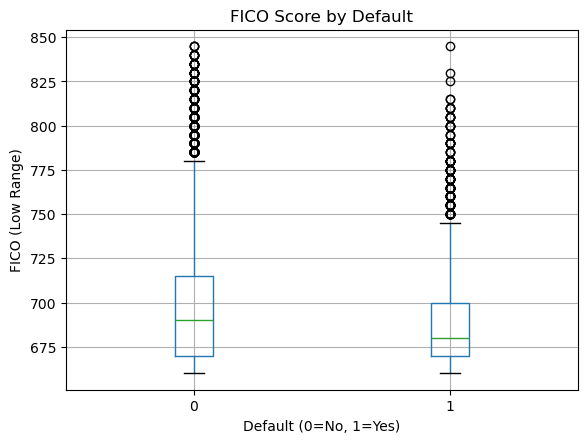

In [22]:
# Credit score distribution by default outcome
df.boxplot(column="fico_range_low", by="default")
plt.title("FICO Score by Default")
plt.suptitle("")
plt.xlabel("Default (0=No, 1=Yes)")
plt.ylabel("FICO (Low Range)")
plt.show()


Defaulted borrowers tend to have lower FICO scores compared to non-defaulted borrowers. This confirms that credit score is an important indicator of default risk.

In [24]:
# Correlation with default (direction + strength)
corr = df.drop(columns=["loan_status"]).corr(numeric_only=True)["default"].sort_values(ascending=False)
corr


default           1.000000
int_rate          0.264423
term              0.187541
dti               0.113448
loan_amnt         0.084212
emp_length       -0.009246
annual_inc       -0.023238
fico_range_low   -0.133042
Name: default, dtype: float64

Interest rate has the strongest positive correlation with default, while FICO score has a negative correlation, indicating that higher credit scores reduce default risk. These relationships are consistent with financial theory.

## Model Building

A logistic regression model is trained to predict loan default using selected borrower and loan features.


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df.drop(columns=["loan_status", "default"])
y = df["default"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [28]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000)

## Model Evaluation

Model performance is evaluated using AUC, ROC curve analysis, and model coefficients.


In [31]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# AUC score
auc = roc_auc_score(y_test, y_pred_prob)
auc


0.7130098805718118

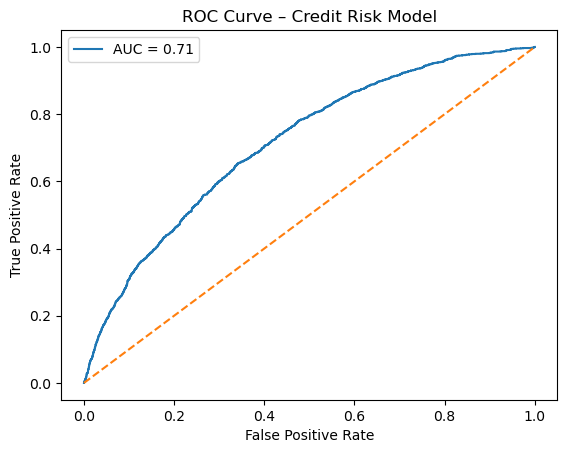

In [32]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Model")
plt.legend()

# SAVE FIRST
plt.savefig("../images/roc_curve.png", dpi=300, bbox_inches="tight")

# THEN show
plt.show()


In [33]:
# Model coefficients
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
1,int_rate,0.405585
6,term,0.233205
3,dti,0.201191
0,loan_amnt,0.073254
2,annual_inc,-0.022957
5,emp_length,-0.029219
4,fico_range_low,-0.259236


## Final Interpretation & Business Insights

The logistic regression model achieved an AUC of 0.71, indicating good ability to distinguish between defaulted and non-defaulted loans.

Interest rate has the strongest positive effect on default risk, followed by loan term and debt-to-income ratio. Borrowers with higher interest rates, longer loan terms, and higher debt burdens are more likely to default.

Credit score shows a strong negative relationship with default, indicating that borrowers with higher FICO scores are less likely to default. Higher income and longer employment history also slightly reduce default risk.

Overall, this model can support credit decision-making by identifying high-risk borrowers and improving loan pricing and approval strategies.
